In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [3]:
# Muat dataset
df = pd.read_csv("../Dataset/Income.csv")
print(df.head())

   age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country income  
0          2174             0              40  United-States  <=50K  
1             0             0             

In [4]:
# Ubah variabel kategori ke biner
label_encoders = {}
for col in df.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [5]:
# Pastikan variabel target adalah biner
df["income"] = (df["income"] > df["income"].median()).astype(int)

In [6]:
#Memisahkan kolom income
X = df.drop(columns=["income"])
y = df["income"]

In [7]:
# Melakukan scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [8]:
# Memisahkan dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
# Konversi ke pytorch tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

In [10]:
# Meload pytorch dataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [11]:
# Membuat model pytorch
class IncomeClassifier(nn.Module):
    def __init__(self):
        super(IncomeClassifier, self).__init__()
        self.fc1 = nn.Linear(14, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [12]:
# Inisialisasi model
model = IncomeClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
# Melatih model
loss_history = []
for epoch in range(20):
    model.train()
    total_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    loss_history.append(total_loss / len(train_loader))
    print(f"Epoch [{epoch+1}/{20}], Loss: {total_loss / len(train_loader):.4f}")

Epoch [1/20], Loss: 0.6123
Epoch [2/20], Loss: 0.5947
Epoch [3/20], Loss: 0.5902
Epoch [4/20], Loss: 0.5879
Epoch [5/20], Loss: 0.5855
Epoch [6/20], Loss: 0.5847
Epoch [7/20], Loss: 0.5828
Epoch [8/20], Loss: 0.5812
Epoch [9/20], Loss: 0.5805
Epoch [10/20], Loss: 0.5801
Epoch [11/20], Loss: 0.5786
Epoch [12/20], Loss: 0.5776
Epoch [13/20], Loss: 0.5768
Epoch [14/20], Loss: 0.5761
Epoch [15/20], Loss: 0.5756
Epoch [16/20], Loss: 0.5740
Epoch [17/20], Loss: 0.5734
Epoch [18/20], Loss: 0.5726
Epoch [19/20], Loss: 0.5727
Epoch [20/20], Loss: 0.5717


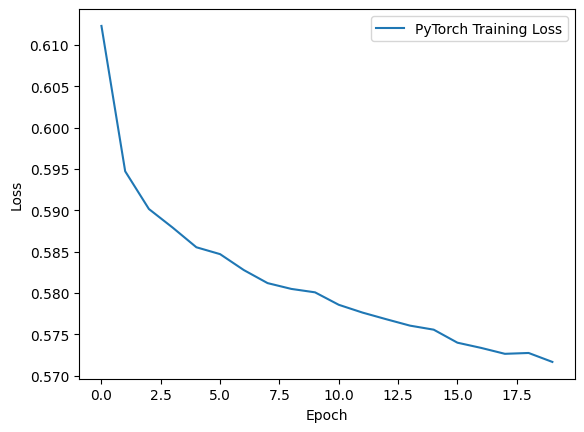

In [14]:
# Visualisasi loss
plt.plot(loss_history, label='PyTorch Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
# Evaluasi model
model.eval()
y_pred_probs = []
y_true = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        probs = torch.softmax(outputs, dim=1)[:, 1]
        y_pred_probs.extend(probs.numpy())
        y_true.extend(batch_y.numpy())

y_pred = (np.array(y_pred_probs) >= 0.5).astype(int)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1_squared = f1_score(y_true, y_pred) ** 2
auc = roc_auc_score(y_true, y_pred_probs)
print("PyTorch Model Evaluation:", accuracy, precision, recall, f1_squared, auc)

PyTorch Model Evaluation: 0.6659842358480909 0.723526044647968 0.5239378238341968 0.3693787284558579 0.7189864723242283


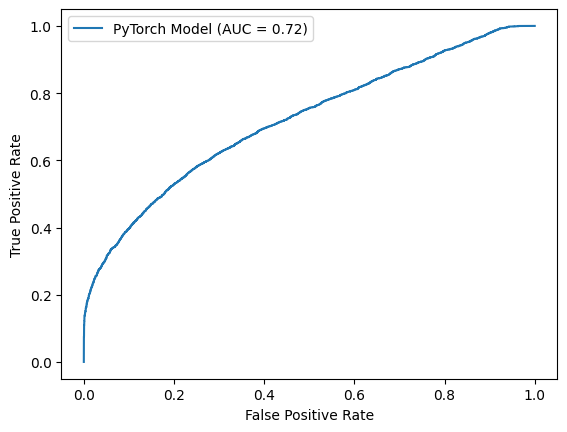

In [16]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
plt.plot(fpr, tpr, label='PyTorch Model (AUC = {:.2f})'.format(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [17]:
# Membuat model tensorflow
tf_model = keras.Sequential([
    layers.Dense(64, activation="relu", input_shape=(14,)),
    layers.Dense(32, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
tf_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history = tf_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

c:\Users\Azka\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6306 - loss: 0.6369 - val_accuracy: 0.6639 - val_loss: 0.6016
Epoch 2/20
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6657 - loss: 0.6012 - val_accuracy: 0.6631 - val_loss: 0.5953
Epoch 3/20
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6687 - loss: 0.5951 - val_accuracy: 0.6664 - val_loss: 0.5919
Epoch 4/20
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6717 - loss: 0.5921 - val_accuracy: 0.6657 - val_loss: 0.5917
Epoch 5/20
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6752 - loss: 0.5868 - val_accuracy: 0.6687 - val_loss: 0.5926
Epoch 6/20
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6771 - loss: 0.5835 - val_accuracy: 0.6704 - val_loss: 0.5899
Epoch 7/20
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6765 - loss: 0.5840 - val_accuracy: 0.6657 - val_loss: 0.5897
Epoch 8/20
1222/1222 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6744 - loss: 0.5813 - 

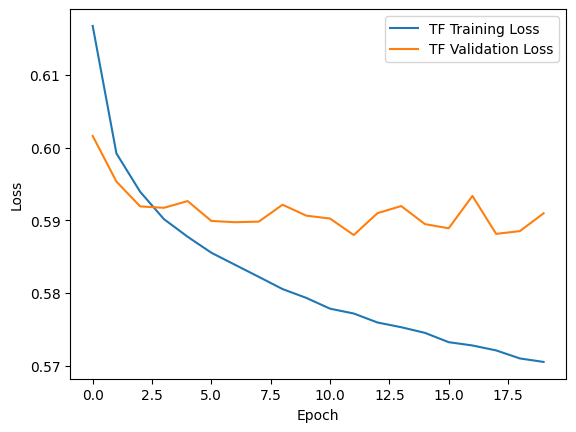

In [18]:
# Visualisasi loss
plt.plot(history.history['loss'], label='TF Training Loss')
plt.plot(history.history['val_loss'], label='TF Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
# Evaluasi model
y_pred_probs_tf = tf_model.predict(X_test).flatten()
y_pred_tf = (y_pred_probs_tf >= 0.5).astype(int)
accuracy_tf = accuracy_score(y_test, y_pred_tf)
precision_tf = precision_score(y_test, y_pred_tf)
recall_tf = recall_score(y_test, y_pred_tf)
f1_squared_tf = f1_score(y_test, y_pred_tf) ** 2
auc_tf = roc_auc_score(y_test, y_pred_probs_tf)
print("TensorFlow Model Evaluation:", accuracy_tf, precision_tf, recall_tf, f1_squared_tf, auc_tf)

306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
TensorFlow Model Evaluation: 0.6689528099088955 0.7171717171717171 0.5444559585492228 0.38315049865819334 0.7218182084947264


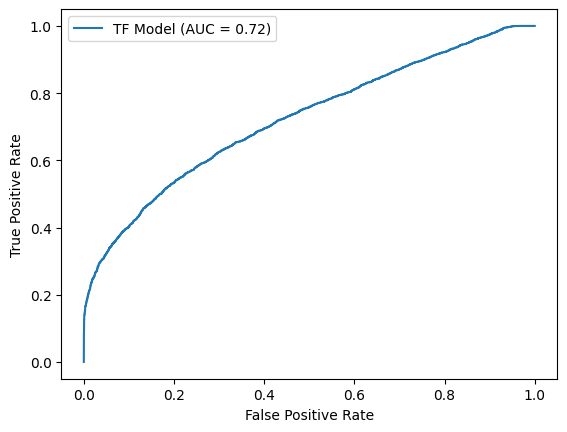

In [20]:
# Plot ROC curve
fpr_tf, tpr_tf, _ = roc_curve(y_test, y_pred_probs_tf)
plt.plot(fpr_tf, tpr_tf, label='TF Model (AUC = {:.2f})'.format(auc_tf))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# 1. Perbandingan Matriks Evaluasi

Berikut adalah hasil evaluasi dari model PyTorch dan TensorFlow berdasarkan beberapa metrik evaluasi:

- **Akurasi**: Mengukur sejauh mana prediksi model sesuai dengan label yang sebenarnya.
- **Presisi**: Menghitung proporsi prediksi positif yang benar dari semua prediksi positif yang diberikan model.
- **Recall**: Mengukur seberapa baik model dalam menemukan semua sampel positif yang sebenarnya.
- **F1-Squared**: Kuadrat dari F1-Score yang menggabungkan presisi dan recall.
- **AUC (Area Under Curve)**: Mengukur kemampuan model dalam membedakan kelas positif dan negatif.
- **ROC Curve**: Grafik yang menunjukkan hubungan antara True Positive Rate (TPR) dan False Positive Rate (FPR).

Berdasarkan hasil evaluasi, metrik yang terbaik tergantung pada tujuan model:
- Jika model digunakan untuk menghindari kesalahan klasifikasi, **Akurasi** lebih penting.
- Jika lebih penting menghindari false positives, **Presisi** lebih utama.
- Jika lebih penting menangkap semua kasus positif, **Recall** yang lebih dominan.
- **F1-Squared** berguna jika ingin menyeimbangkan antara presisi dan recall.
- **AUC & ROC** lebih cocok untuk membandingkan model dengan berbagai threshold.

---

# 2. Penjelasan Persamaan Matematika

## Akurasi
Akurasi dihitung dengan:
```plaintext
Akurasi = (Jumlah Prediksi Benar) / (Jumlah Total Sampel)
```
Semakin tinggi akurasi, semakin baik performa model dalam mengklasifikasikan data dengan benar.

## Presisi
Presisi dihitung dengan:
```plaintext
Presisi = (True Positives) / (True Positives + False Positives)
```
Presisi mengukur keandalan prediksi positif model.

## Recall
Recall dihitung dengan:
```plaintext
Recall = (True Positives) / (True Positives + False Negatives)
```
Recall menunjukkan seberapa baik model menangkap semua sampel positif.

## F1-Squared
F1-Score dihitung dengan:
```plaintext
F1 = 2 * (Presisi * Recall) / (Presisi + Recall)
```
Kemudian nilai ini dikuadratkan untuk mendapatkan **F1-Squared**:
```plaintext
F1-Squared = F1^2
```
Nilai ini membantu jika kita ingin memberikan penalti lebih besar terhadap model yang memiliki keseimbangan buruk antara presisi dan recall.

## AUC (Area Under Curve)
AUC mengukur luas di bawah kurva ROC dan menunjukkan seberapa baik model dalam membedakan kelas positif dan negatif. Nilai berkisar antara 0 hingga 1, di mana semakin tinggi, semakin baik modelnya.

## ROC Curve
ROC Curve adalah grafik yang dibuat dengan menghitung:
```plaintext
TPR = (True Positives) / (True Positives + False Negatives)
FPR = (False Positives) / (False Positives + True Negatives)
```
Semakin jauh kurva dari garis diagonal, semakin baik modelnya.

